In [1]:
%load_ext autoreload
%autoreload 2

### Load libraries and paths

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymc as pm 
import arviz as az
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_population_to_classes, 
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    apply_encoding, 
                                    naturraumregionen_encoding, 
                                    map_to_binary)
from src.modeling.utils import temporal_train_test_split, save_model, load_model
from src.modeling.bayesian_models import create_blr_v2, create_st_blr_v2, create_bnn, create_st_intercept_blr_v2
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN
from src.visualization import (plot_st_sample_size_distribution, 
                               plot_performance_over_test_years)
from src.data_preprocessing.fire_events_sampling import sample_points
from src.data_preprocessing.feature_engineering import add_static_features, add_ffmc_feature


In [4]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [5]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

### Data Cleaning & Preparation

In [6]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

training_data['season'] = training_data['date'].dt.month.apply(lambda x: (
    3 if x in [12, 1, 2] else
    0 if x in [3, 4, 5] else
    1 if x in [6, 7, 8] else
    2 
))

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

/tmp/ipykernel_10981/2105497721.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data["forest_type"].fillna(6, inplace=True)


### Temporal train test split

In [7]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


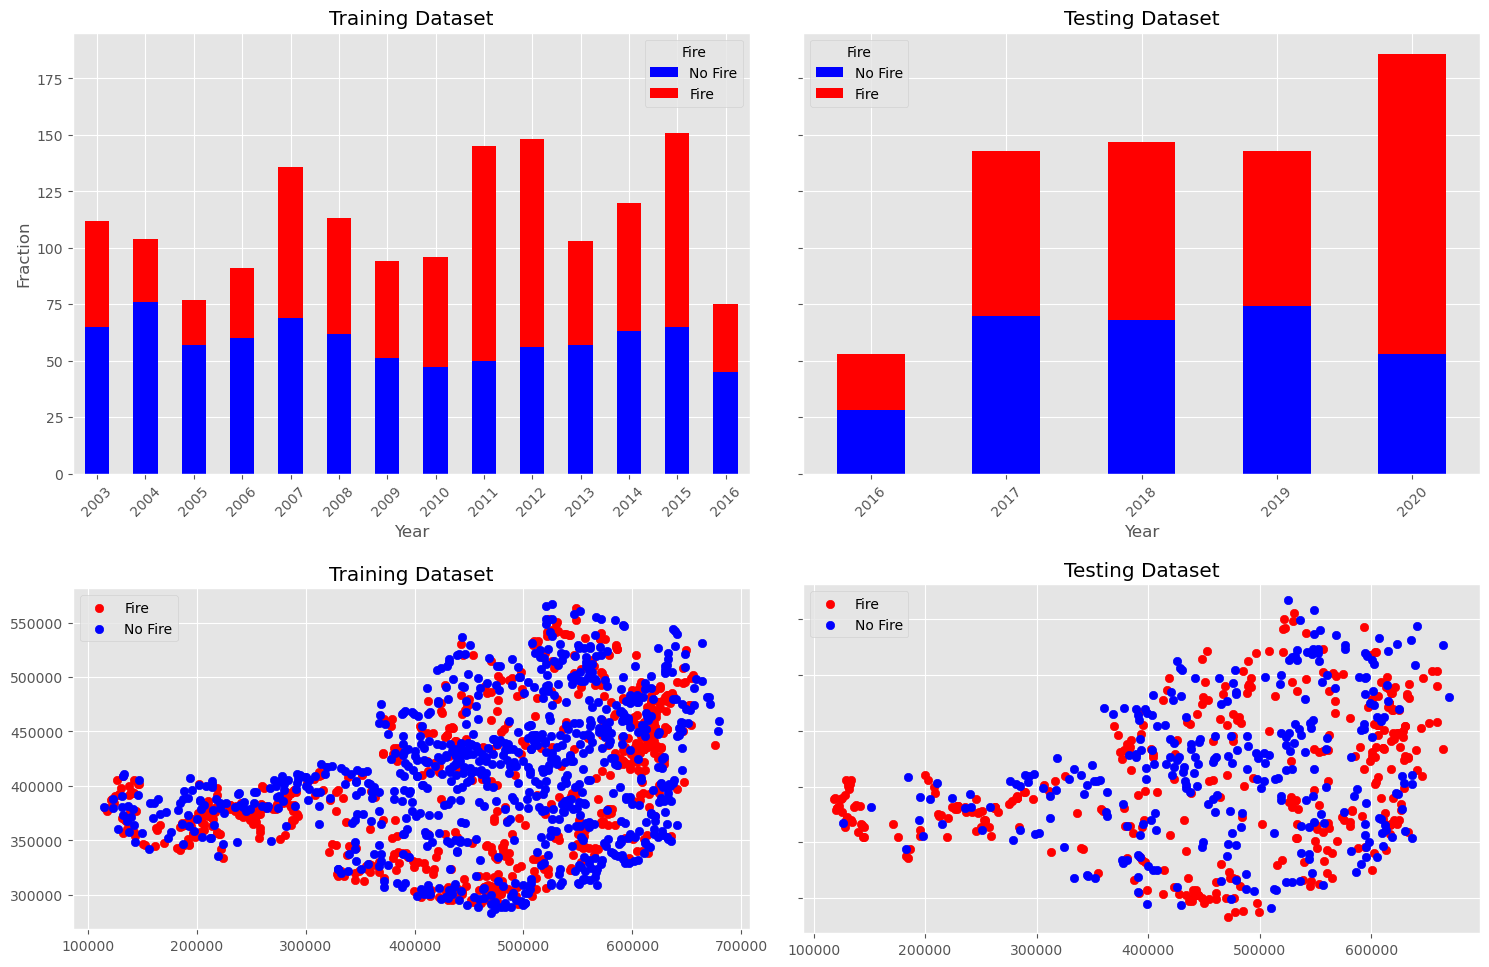

In [8]:
# Plotting the distribution of fire and no-fire samples for train and test set
plot_st_sample_size_distribution(X_train_unprocessed, X_test_unprocessed, r"../../../results/train_test_distribution.png")

### Feature Preprocessing

In [23]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled


# feature processing for BNN
#features_to_scale = ['ffmc', 'farmyard_density',
#       'hikingtrail_density', 'forestroad_density', 'railway_density',
#       'elevation', 'slope', 'population_density']
#features_bnn_ohe = ['aspect_encoded', 'forest_type']

features_to_scale = ["ffmc"]
features_to_ohe = ["elevation_encoded", "slope_encoded", "aspect_encoded", 
                   "population_encoded", "farmyard_density_bin", "forestroad_density_bin", 
                   "railway_density_bin", "hikingtrail_density_bin", "forest_type"]

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_to_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [24]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [11]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr_v2(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=30000, random_seed=0)
    blr_idata = approx.sample()
    pm.compute_log_likelihood(blr_idata)

save_model("../../../models/blr_v2.pkl", model_blr, blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 780.27


Output()

In [12]:
model_st_intercept_blr = create_st_intercept_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=30000, random_seed=0)
    st_intercept_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_intercept_blr_idata)

save_model("../../../models/st_intercept_blr_v2.pkl", model_st_intercept_blr, st_intercept_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 770.88


Output()

In [13]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=30000, random_seed=0)
    st_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_blr_idata)

save_model("../../../models/st_blr_v2.pkl", model_st_blr, st_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,210.1


Output()

In [40]:
X_train_bnn

<1565x40 sparse matrix of type '<class 'numpy.float64'>'
	with 15650 stored elements in Compressed Sparse Row format>

In [41]:
model_bnn = create_bnn(X_train_bnn.toarray(), y_train)

with model_bnn:
    approx = pm.fit(n=30000, random_seed=0)
    bnn_idata = approx.sample()

save_model("../../../models/bnn.pkl", model_bnn, bnn_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,036.8


### Out-of-sample prediction

In [42]:
# open saved models
model_blr, idata_blr = load_model("../../../models/blr_v2.pkl")
model_st_blr, idata_st_blr = load_model("../../../models/st_blr_v2.pkl")
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../../models/st_intercept_blr_v2.pkl")
model_bnn, idata_bnn = load_model("../../../models/bnn.pkl")

In [43]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [46]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, idata_blr, X_new_blr, seed, "y_pred", "p")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, seed, "y_pred", "p")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, idata_st_blr, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, idata_bnn, X_test_bnn.toarray(), seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

### Analyze & Visualize results

#### Calculate overall model performance

In [47]:

print("BLR Accuracy: ", accuracy_score(y_test, blr_preds.y_pred))
print("BLR Precision: ", precision_score(y_test, blr_preds.y_pred))
print("BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", accuracy_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR Precision: ", precision_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR  Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_intercept_blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST BLR Accuracy: ", accuracy_score(y_test, st_blr_preds.y_pred))
print("ST BLR Precision: ", precision_score(y_test, st_blr_preds.y_pred))
print("ST BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_blr_preds.hdi_width.mean())

print("---------------------------------")

print("BNN Accuracy: ", accuracy_score(y_test, bnn_preds.y_pred))
print("BNN Precision: ", precision_score(y_test, bnn_preds.y_pred))
print("BNN Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", bnn_preds.hdi_width.mean())

BLR Accuracy:  0.7738095238095238
BLR Precision:  0.8289855072463768
BLR Recall:  0.7546174142480211
HDI width:  0.1716772116304794
---------------------------------
ST Intercept BLR Accuracy:  0.7723214285714286
ST Intercept BLR Precision:  0.8247126436781609
ST Intercept BLR  Recall:  0.7546174142480211
HDI width:  0.2004312487895304
---------------------------------
ST BLR Accuracy:  0.7559523809523809
ST BLR Precision:  0.7866666666666666
ST BLR Recall:  0.7546174142480211
HDI width:  0.4018752491393827
---------------------------------
BNN Accuracy:  0.7678571428571429
BNN Precision:  0.7973333333333333
BNN Recall:  0.7546174142480211
HDI width:  0.29017069999070727


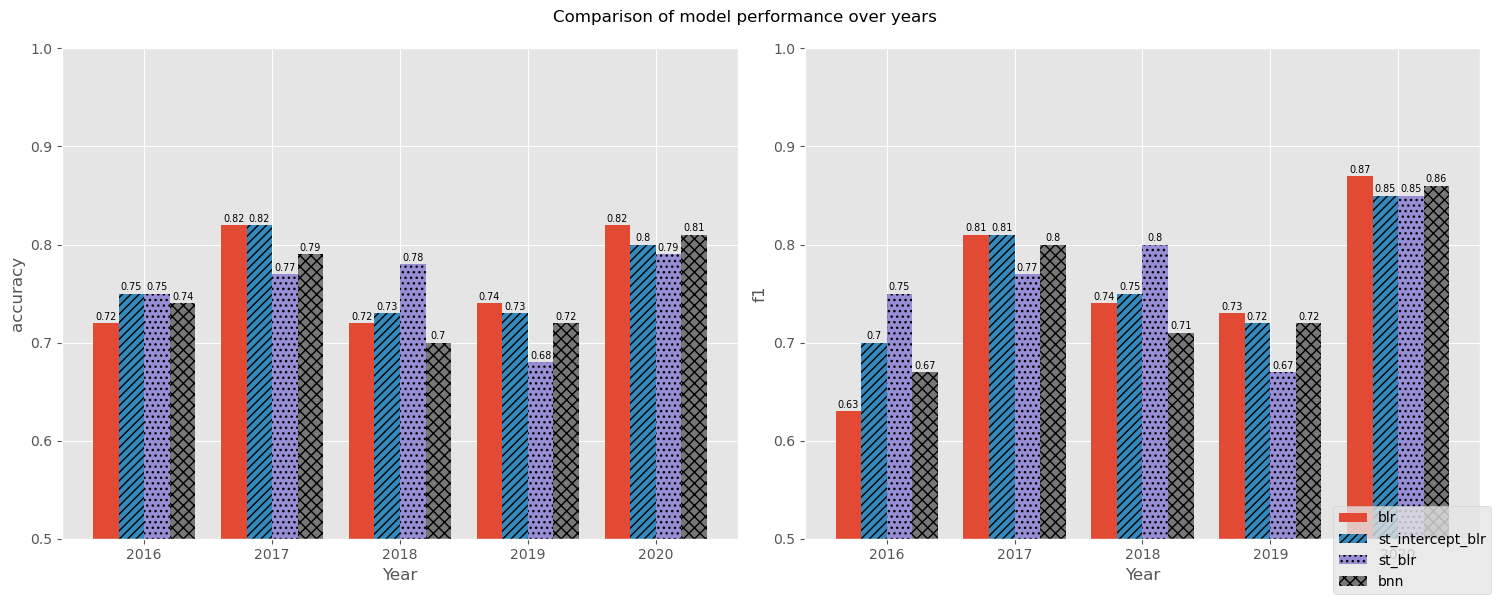

In [22]:
# Performance (Accuracy & F1) over years and across seasons (4 plots)
model_preds = [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]
plot_performance_over_test_years(model_preds, X_test, y_test, "../../../results/model_performance_over_years.png")

#### Plot spatio-temporal model performance

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_10981/2734504663.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_st_grouped = preds.groupby(["spatial_group", "temporal_group"]).apply(calculate_st_metrics).reset_index()


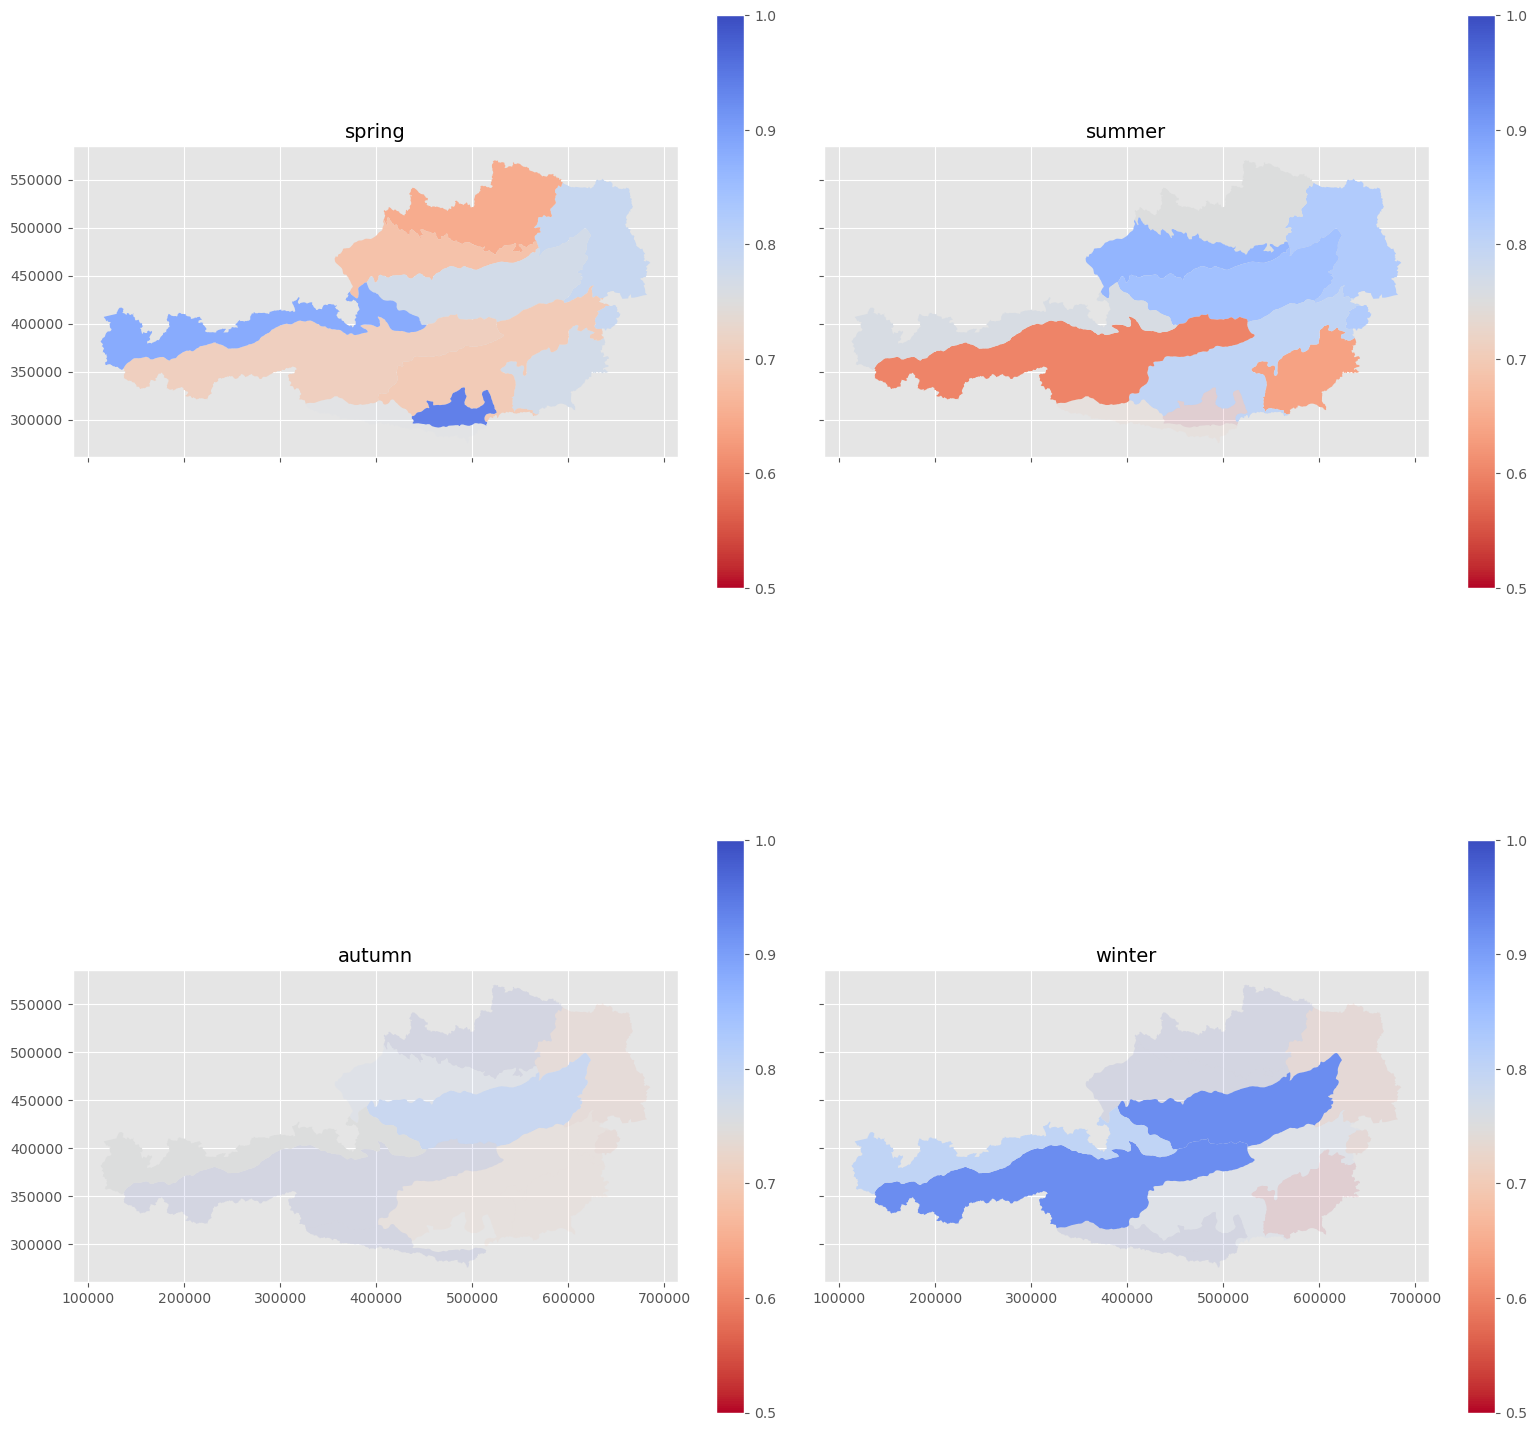

In [65]:
spatial_groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
temporal_groups = [0, 1, 2, 3]
naturraumregionen["EINHEIT_encoded"] = naturraumregionen["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

preds = st_intercept_blr_preds.copy()
preds["spatial_group"] = X_test.naturraumregionen_encoded.values
preds["temporal_group"] = X_test.season.values
preds["y_true"] = y_test.values

def calculate_st_metrics(group):
    accuracy = accuracy_score(group['y_true'], group['y_pred'])
    f1 = f1_score(group['y_true'], group['y_pred'])
    sample_size = len(group)
    return pd.Series({'accuracy': accuracy, 'f1': f1, 'sample_size': sample_size})

preds_st_grouped = preds.groupby(["spatial_group", "temporal_group"]).apply(calculate_st_metrics).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 20), sharex="col", sharey="row")
seasons = ["spring", "summer", "autumn", "winter"]

for i in temporal_groups:
    ax = axes[i // 2, i % 2]
    gdf = pd.merge(naturraumregionen, preds_st_grouped[preds_st_grouped.temporal_group == i], left_on="EINHEIT_encoded", right_on="spatial_group")
    gdf['alpha'] = gdf['sample_size'].apply(lambda x: 1 if x > 10 else 0.1)
    im1 = gdf.plot(column="accuracy", cmap="coolwarm_r", legend=True, ax=ax, vmin=0.5, vmax=1, legend_kwds={"shrink":.5}, alpha=gdf.alpha)
    ax.set_title(f'{seasons[i]}', fontsize=14) 

plt.tight_layout()
plt.show()

#### Plot uncertainty associated with each spatio-temporal unit

##### Model Assumptions:

In the varying intercept logistic regression model, the following assumptions are made:

**Consistent Feature Relationships**: The relationship between the predictor variables (features) and the risk of fire ignition is assumed to be consistent across different seasons and spatial regions. This implies that the effect of each predictor on the likelihood of fire ignition is uniform throughout the study area and time periods.

**Spatio-Temporal Variability**: While the relationships between features and fire ignition risk are consistent, there are assumed to be unobserved factors that vary across both spatial regions and seasons. These unobserved factors contribute to differences in fire ignition risk that are not captured by the predictor variables. To account for this, the model includes a varying intercept that allows for regional and seasonal variations in the baseline risk of fire ignition.

**Hierarchical Structure**: The model is hierarchical, meaning that the intercepts for each region and season are treated as random effects. This hierarchical structure allows the model to borrow strength across regions and seasons, providing more robust estimates by acknowledging the nested nature of the data.

**Intercept Variation**: The varying intercepts capture the unique baseline level of fire ignition risk for each region-season combination, reflecting the influence of unobserved regional and seasonal factors. This means that the model adjusts the overall risk estimate for each region and season, accounting for systematic differences not explained by the measured features.

In [92]:
data = [
    {
        "EINHEIT": key,
        "season": season,
        "intercept": idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].mean(axis=0).values[value],
        "hdi_96_min": az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].values, hdi_prob=0.96)[value][0],
        "hdi_96_max": az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].values, hdi_prob=0.96)[value][1]

    }
    for season_id, season in enumerate(range(len(seasons)))
    for key, value in naturraumregionen_encoding.items()
]

df_spatio_temporal_intercept = pd.DataFrame(data).merge(naturraumregionen, on="EINHEIT")
df_spatio_temporal_intercept["hdi_width"] = df_spatio_temporal_intercept["hdi_96_max"] - df_spatio_temporal_intercept["hdi_96_min"]

/tmp/ipykernel_380191/1006517188.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  "hdi_96_min": az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].values, hdi_prob=0.96)[value][0],
/tmp/ipykernel_380191/1006517188.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  "hdi_96_max": az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].values, hdi_prob=0.96)[value][1]
/tmp/ipykernel_380191/1006517188.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  "hdi_96_min": az.hdi(idata_st_intercept_blr.posterior.intercept[0, :, :, season_id].values, hdi_prob=0.96)[value][0],
/tmp/ipykernel_380191/1006517188.py:7: FutureWarni

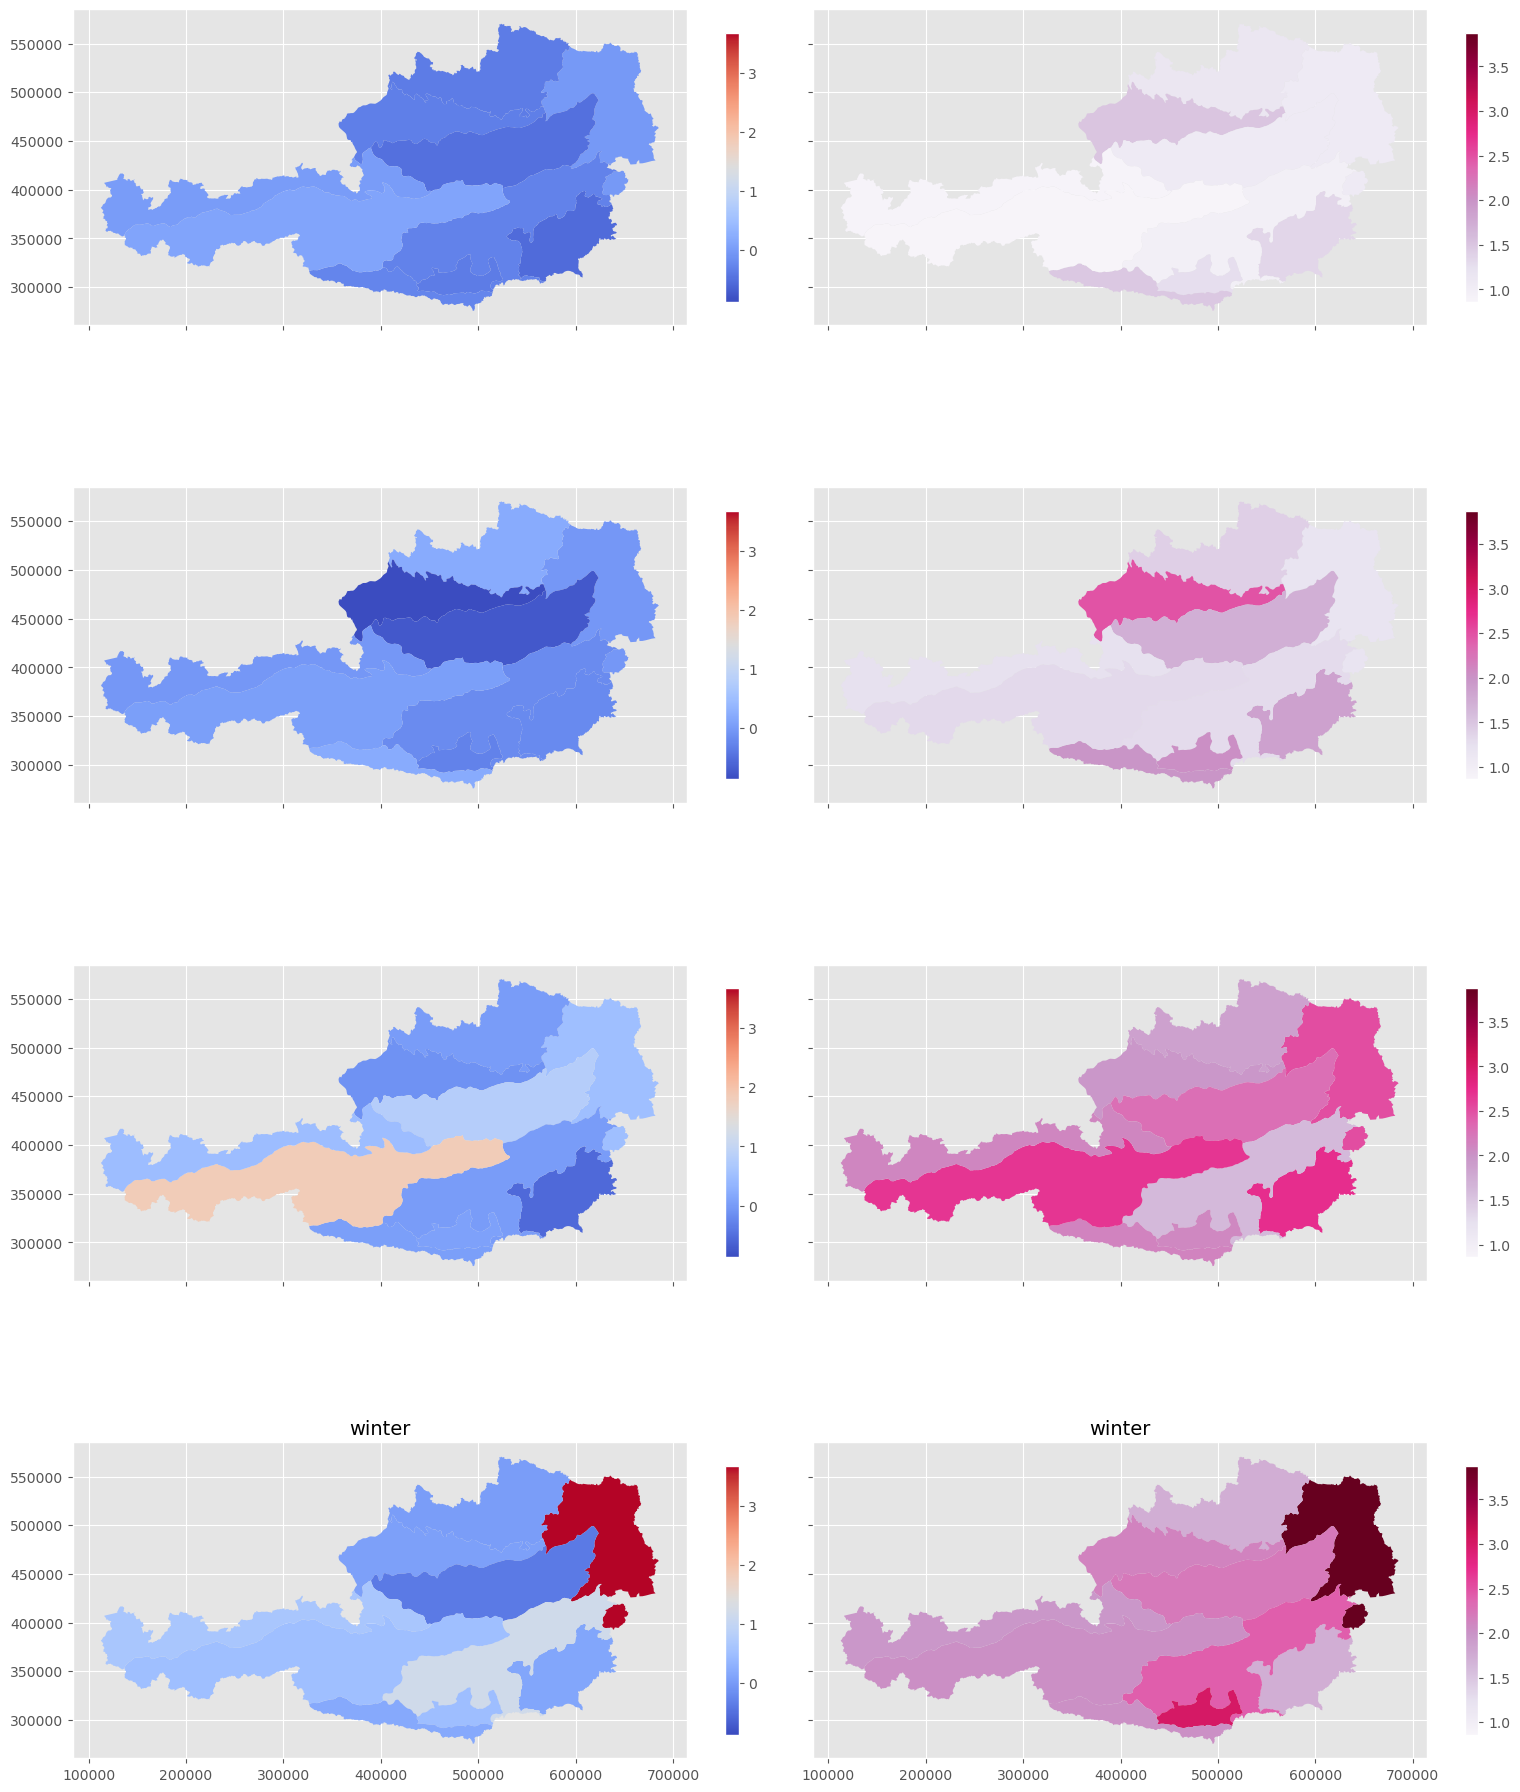

In [93]:
gdf = gpd.GeoDataFrame(df_spatio_temporal_intercept, geometry='geometry')

fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex="col", sharey="row")
seasons = ["spring", "summer", "autumn", "winter"]

for season_id, season in enumerate(range(len(seasons))):
    season_gdf = gdf[gdf['season'] == season_id]
    season_gdf.plot(column='intercept', cmap="coolwarm", legend=True, ax=axes[season_id, 0], vmin=gdf['intercept'].min(), vmax=gdf['intercept'].max(), legend_kwds={"shrink":.5})
    season_gdf.plot(column='hdi_width', cmap="PuRd", legend=True, ax=axes[season_id, 1], vmin=gdf['hdi_width'].min(), vmax=gdf["hdi_width"].max(), legend_kwds={"shrink":.5})

    axes[i, 0].set_title(f'{seasons[i]}', fontsize=14) 
    axes[i, 1].set_title(f'{seasons[i]}', fontsize=14) 

plt.tight_layout()
plt.show()


#### Plot score and uncertainty for each spatio-temporal subgroup for sampled data 


##### Approach
- Create stratified random sample for 2021
- Enrich with features
- Make predictions using the varying intercept model
- Create 4 (or 8) maps, visualizing fire ignition risk & associated uncertainty expressed as mean hdi width

##### Sampling 

In [94]:
nr_samples = 20000
random_points_forest = sample_points(paths["forest_type"]["final"], nr_samples, random_seed=0)
random_points_forest.to_file("/home/david/Downloads/random_fire_points.shp")
random_points_forest["date"] = pd.date_range(start="01-01-2021", end="31-12.2023", periods=nr_samples)

sampled_gdf = gpd.sjoin(random_points_forest, naturraumregionen, how='inner', op='within')

def sample_by_category(group):
    return group.sample(n=min(len(group), 200), random_state=42)

sampled_gdf = sampled_gdf.groupby('EINHEIT', group_keys=False).apply(sample_by_category)

sampled_gdf["x"] = sampled_gdf.geometry.x
sampled_gdf["y"] = sampled_gdf.geometry.y
sampled_gdf["year"] = sampled_gdf.date.dt.year
sampled_gdf["month"] = sampled_gdf.date.dt.month
sampled_gdf["day"] = sampled_gdf.date.dt.day

sampled_gdf.to_csv("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples.csv")

sampled_gdf['season'] = sampled_gdf['date'].dt.month.apply(lambda x: (
    3 if x in [12, 1, 2] else
    0 if x in [3, 4, 5] else
    1 if x in [6, 7, 8] else
    2 
))

sampled_gdf["date"] = sampled_gdf["date"].dt.date.astype("str")
sampled_gdf = sampled_gdf.loc[:, ["date", "season", "EINHEIT", "geometry"]]
sampled_gdf["naturaumregionen_encoded"] = sampled_gdf["EINHEIT"].map(naturraumregionen_encoding)

sampled_gdf.to_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples.shp")


/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_380191/1523160715.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_gdf = sampled_gdf.groupby('EINHEIT', group_keys=False).apply(sample_by_category)
/tmp/ipykernel_380191/1523160715.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sampled_gdf.to_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/d

##### Feature Engineering

In [96]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

event_data = gpd.read_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples.shp")
event_data.reset_index(inplace=True)

feature_info = [
    ("pop_2006", paths["population_layers"]["2006"]["final"]),
    ("pop_2011", paths["population_layers"]["2011"]["final"]),
    ("pop_2018", paths["population_layers"]["2018"]["final"]),
    ("pop_2021", paths["population_layers"]["2021"]["final"]),
    ("farmyard_ds", paths["farmyard_density"]["final"]),
    ("hiking_ds", paths["roads"]["hikingtrails"]["final"]),
    ("forest_ds", paths["roads"]["forestroads"]["final"]),
    ("rail_dens", paths["railways"]["final"]),
    ("elevation", paths["topographical_layers"]["elevation"]["final"]),
    ("slope", paths["topographical_layers"]["slope"]["final"]),
    ("aspect", paths["topographical_layers"]["aspect"]["final"]),
    ("foresttype", paths["forest_type"]["final"]),
    ("canopy_cover", paths["canopy_cover"]["final"]),
]

inference_data = add_static_features(BASE_PATH, event_data, feature_info)
#train_data = add_ffmc_feature(train_data, paths["ffmc_events"]["source"])
inference_data["ffmc"] = np.random.randint(low=50, high=99, size=2000)

inference_data.to_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples_enriched.shp")

/tmp/ipykernel_380191/4267729066.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  inference_data.to_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples_enriched.shp")


##### Prediction 

In [97]:
# load model and inference data
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../../models/st_intercept_blr_v2.pkl")
inference_data = gpd.read_file("/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/uncertainty_quantification/samples_enriched.shp")

In [98]:
# rename columns
inference_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

inference_data["naturraumregionen_encoded"] = inference_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

# encode features into predefined classes
inference_data["elevation_encoded"] = inference_data["elevation"].apply(convert_elevation_to_classes)
inference_data["slope_encoded"] = inference_data["slope"].apply(convert_slope_to_classes)
inference_data["aspect_encoded"] = inference_data["aspect"].apply(convert_aspect_to_cardinal_direction)
inference_data["population_encoded"] = inference_data["population_density"].apply(convert_population_to_classes)

# binarize features
inference_data["farmyard_density_bin"] = inference_data["farmyard_density"].apply(map_to_binary)
inference_data["forestroad_density_bin"] = inference_data["forestroad_density"].apply(map_to_binary)
inference_data["railway_density_bin"] = inference_data["railway_density"].apply(map_to_binary)
inference_data["hikingtrail_density_bin"] = inference_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
inference_data["forest_type"].fillna(6, inplace=True)
inference_data["forest_type"] = inference_data["forest_type"].astype(int)

/tmp/ipykernel_380191/951955289.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inference_data["forest_type"].fillna(6, inplace=True)


In [99]:
inference_data_ffmc_scaled = preprocessor_blr.transform(inference_data)
inference_data_processed = inference_data.copy()
inference_data_processed["ffmc"] = inference_data_ffmc_scaled

In [100]:
data = inference_data_processed.copy()
y_dummy = [0 for i in range(len(data))]
X_new_st_blr = {
    "elevation": data.elevation_encoded,
    "slope": data.slope_encoded,
    "aspect": data.aspect_encoded,
    "forestroad_density": data.forestroad_density_bin,
    "railway_density": data.railway_density_bin,
    "hikingtrail_density": data.hikingtrail_density_bin,
    "farmyard_density": data.farmyard_density_bin,
    "population": data.population_encoded,
    "forest_type": data.forest_type,
    "ffmc": data.ffmc,
    "fire": y_dummy
    }

X_new_st_blr["spatial_groups_idx"] = data.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = data.season

In [101]:
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, 0, "y_pred", "p")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

Sampling: [y_pred]


Output()

In [112]:
results = st_intercept_blr_preds.copy()
results["season"] = data.season
results["EINHEIT"] = data.EINHEIT
results["geometry"] = data.geometry
results = gpd.GeoDataFrame(results, geometry="geometry")

In [113]:
results.groupby(by="season").agg({"p_pred": "mean", "hdi_width": "mean"})

,p_pred,hdi_width
season,,
0,0.182692,0.079132
1,0.218840,0.111843
2,0.240727,0.105030
3,0.282391,0.139281
